# Install acspype

acspype can be installed using pip:

`pip install acspype`

Code documentation for acspype can be found at [https://iantblack.github.io/acspype/](https://iantblack.github.io/acspype/).

## Import Required Packages for this Example

In [1]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator
from matplotlib.ticker import MultipleLocator
import numpy as np

from acspype import ACSTSCor
import acspype.processing as acsproc # Module level wrapper around processing functions.
import acspype.qaqc as acsqaqc # Module level wrapper around qaqc functions.
from acspype.experimental import estimate_chl

from acspype.utils.ooi import download_and_load_goldcopy, reformat_ooi_optaa, get_ooi_optaa_cal  # Convenience functions for OOI data. These have not been thoroughly tested outside of this example.

# OOI CE02SHSP Example


In this example, we will be using ACS data from the [OOI Oregon Shelf Coastal Surface Piercing Profiler (CE02SHSP)](https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered/catalog.html). 

This data contains upward profiles of ACS data from roughly 75m depth to the sea-surface. The data used in this example are from a deployment where the profiler failed to follow its prescribed sampling regime and instead collected a profile every 20 minutes for 3 days before its batteries died. In total, roughly 132 thousand ACS samples were taken.

The data made available from OOI already has the nearest neighbor salinity, temperature, and pressure assigned to each ACS timestamp. One thing to consider is that the ACS data from the OOI are not time-lag corrected in these datasets. For simplicity, this example does not handle andy time-lag correction or consider the different heights of the sensors on the profiler.

#### Download, Select, and Reformat OOI Data

OOI NetCDFs accessed through OpenDAP are not CF compliant, which may result in datatype conversions that create invalid values (e.g. unsigned integer converted to signed integer). The reconversion to the appropriate datatype would add extra steps to this example, so instead this example downloads the file, which should have the appropriate datatypes. 

If you inspect the data before it is reformatted, you'll find that it has the dimensions of `obs` and `wavelength`. These two dimensions are not compatible with *acspype* and do not provide any meaningful information that can't already be determined by inspecting the shape of the data. `obs` is simply an iterative identifier for a file and does not express the uniqueness of the sample (a better use would be the UUID). `wavelength`, in this instance, is also an iterative identifier and not actually representative of the actual wavelength, but rather the index of the wavelength bin. This is particularly confusing because variables associated with absorption will have different wavelengths compared to those associated with attenuation. ACS data is much better represented by the dimensions of `a_wavelength` and `c_wavelength`, which are unique and attached to specific absorption and attenuation variables. Later in this example we will show how to linearly interpolate between wavelengths to obtain common bins, which makes it easier to perform scattering correction on ACS data.

Since all OOI assets with an ACS are (currently) immobile and files ***SHOULD*** only contain data from one ACS, the reformatted dataset reassigns latitude, longitude, and deployment as coordinates rather than variables. If continuing to use Xarray, the acspype functions should handle these extra dimensions, but this example will whittle the dataset down to the coordinates of `time`, `a_wavelength`, and `c_wavelength` for simplicity.

In [2]:
acs_url = 'https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/ooigoldcopy/public/CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered/deployment0013_CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered_20190624T165543.774000-20190627T023924.583000.nc'
acs = download_and_load_goldcopy(thredds_fileserver_url=acs_url,
                                 save_dir = 'ooi_data/')

In [3]:
acs # ACS data before reformatting

<xarray.Dataset> Size: 393MB
Dimensions:                       (obs: 131979, wavelength: 86)
Coordinates:
  * obs                           (obs) int32 528kB 0 1 2 ... 131977 131978
    lat                           (obs) float64 1MB ...
  * wavelength                    (wavelength) int32 344B 0 1 2 3 ... 83 84 85
    lon                           (obs) float64 1MB ...
    depth                         (obs) float64 1MB ...
    time                          (obs) datetime64[ns] 1MB ...
Data variables: (12/30)
    external_temp_raw             (obs) float32 528kB ...
    c_signal_counts               (obs, wavelength) float32 45MB ...
    deployment                    (obs) int32 528kB ...
    a_signal_counts               (obs, wavelength) float32 45MB ...
    int_ctd_pressure              (obs) float64 1MB ...
    a_reference_counts            (obs, wavelength) float32 45MB ...
    ...                            ...
    preferred_timestamp           (obs) object 1MB ...
    a_signal_dark_counts          (obs) float32 528kB ...
    c_reference_counts            (obs, wavelength) float32 45MB ...
    a_reference_dark_counts       (obs) float32 528kB ...
    suspect_timestamp             (obs) float32 528kB ...
    sea_water_temperature         (obs) float64 1MB ...
Attributes: (12/68)
    node:                               SP001
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -123.69743
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

The `reformat_ooi_optaa` utility function removes the OOI-processed beam attenuation and optical absorption. These variables do not consider discontinuity or zero shift correction. In this example, we will recalculate these variables from the raw data, so they are removed in the cell below. Note that this function may not be maintained in acspype in the future if significant changes to OOI ACS files are made.

Because the reformat_ooi_optaa function only considers a single ACS file, the deployment information is reassigned as a coordinate rather than a variable. This results in additional dimensions to consider when processing and merging multiple ACS data. For simplicity, this example subsets the dataset to reduce the dimensions to consider in processing.

In [4]:
acs = reformat_ooi_optaa(ds = acs)
acs = acs.sel(latitude = float(acs.latitude), longitude = float(acs.longitude), deployment = int(acs.deployment))

In [5]:
acs  # ACS data after reformatting

<xarray.Dataset> Size: 191MB
Dimensions:                       (time: 131979, a_wavelength: 86,
                                   c_wavelength: 86)
Coordinates:
    latitude                      float64 8B 44.63
    longitude                     float64 8B -123.7
    deployment                    int32 4B 13
    depth                         (time) float64 1MB ...
  * time                          (time) datetime64[ns] 1MB 2019-06-24T16:55:...
  * a_wavelength                  (a_wavelength) float64 688B 401.2 ... 746.8
  * c_wavelength                  (c_wavelength) float64 688B 399.4 ... 749.7
Data variables: (12/14)
    a_reference                   (time, a_wavelength) float32 45MB 604.0 ......
    a_reference_dark              (time) float32 528kB 473.0 473.0 ... 471.0
    a_signal                      (time, a_wavelength) float32 45MB 462.0 ......
    a_signal_dark                 (time) float32 528kB 709.0 709.0 ... 712.0
    c_reference                   (time, c_wavelength) float32 45MB 614.0 ......
    c_reference_dark              (time) float32 528kB 476.0 476.0 ... 475.0
    ...                            ...
    elapsed_time                  (time) float32 528kB 5.041e+04 ... 2.107e+05
    raw_external_temperature      (time) float32 528kB 4.116e+04 ... 3.889e+04
    raw_internal_temperature      (time) float32 528kB 5.149e+04 ... 5.079e+04
    sea_water_practical_salinity  (time) float64 1MB 33.98 34.01 ... 31.18 31.18
    sea_water_pressure            (time) float64 1MB 77.44 77.44 ... 0.742
    sea_water_temperature         (time) float64 1MB 7.288 7.288 ... 15.22 15.21
Attributes: (12/59)
    AssetManagementRecordLastModified:  2023-06-02T18:55:55.111000
    AssetUniqueID:                      CGINS-OPTAAJ-00138
    Conventions:                        CF-1.6
    Description:                        Spectrophotometer: OPTAA Series J
    FirmwareVersion:                    Not specified.
    Manufacturer:                       WET Labs
    ...                                 ...
    time_coverage_end:                  2019-06-27T02:39:24.583000
    time_coverage_resolution:           P1.57S
    time_coverage_start:                2019-06-24T16:55:43.774000
    title:                              Data produced by Stream Engine versio...
    uuid:                               62529081-0c5a-42f1-a139-b717249fdf1e
    number_of_output_wavelengths:       86

#### Download OOI Device Calibration Information
Normally, you would use the `ACSDev` class to import device calibration information from the ACS device file (ACS-XXX.dev). However, the OOI does not make these easily accessible for download. They do provide the coefficients in JSON form through their REST API. The `get_ooi_optaa_cal` function will download the device file information via the OOI REST API and return an `ACSDev`-compatible object with the calibration information.

In [6]:
dev = get_ooi_optaa_cal(ds = acs) # The get_ooi_optaa_cal function uses the uid in the dataset attributes.

In [7]:
print('dev class accessible attributes:', [v for v in dir(dev) if "__" not in v])
print(dev.a_wavelength)

dev class accessible attributes: ['a_delta_t', 'a_offset', 'a_wavelength', 'c_delta_t', 'c_offset', 'c_wavelength', 'func_a_delta_t', 'func_c_delta_t', 'path_length', 'tbin', 'tcal']
[401.2, 405.1, 408.5, 412.3, 415.8, 419.9, 424.2, 428.5, 432.5, 436.6, 440.7, 445.3, 449.5, 454.1, 458.7, 462.6, 467.3, 471.9, 476.2, 480.8, 485.3, 489.7, 494.2, 498.2, 502.6, 506.9, 511.4, 516.6, 520.4, 524.9, 529.4, 533.2, 537.2, 541.5, 545.9, 550.2, 554.0, 558.2, 562.8, 567.3, 570.7, 574.7, 578.6, 580.3, 583.9, 587.6, 591.3, 595.4, 599.6, 603.5, 608.0, 612.2, 616.7, 620.9, 625.2, 629.5, 633.5, 637.5, 641.8, 646.5, 650.4, 654.7, 659.0, 663.4, 667.3, 671.8, 676.2, 680.1, 684.3, 687.9, 691.8, 695.4, 699.1, 703.0, 707.1, 710.7, 714.5, 717.9, 721.9, 725.3, 728.9, 732.6, 736.4, 739.9, 743.5, 746.8]


#### Quick Verification of Data and Device File
The device file is a file that is unique to each ACS. For OOI datasets, one way to verify that you have the correct device file information is to verify that the wavelength values match between the file and the calibration information. In some rare cases, two calibration files for the same instrument may have the same wavelengths, so it is important to use the calibration information that happens before the data collection and is closest to the first timestamp in the dataset. The `get_ooi_optaa_cal` function does this automatically, so there is no need to worry about this for this example. There are more complex ways to compare the device file to the sensor output, but for this example, comparing the wavelengths is sufficient.

In [8]:
assert np.all(dev.a_wavelength == acs.a_wavelength)  # Will raise an error if the wavelengths do not match.

## Reprocess Data

The processing steps in the cells below follow most of the steps outline in the [Recommended Processing Steps (1.0 - 4.1)](https://github.com/IanTBlack/acspype/blob/main/info/PROCESSING.md) in the *acspype* documentation. There are several key things to note about OOI data in relation to the optional steps in this table.
We

This examples skips the following steps:
- Step 1.5: Application of User-Collected Pure Water Coefficients. These are sometimes performed by the OOI, but are not easily accessible and require formatting to work with *acspype*. For the sake of brevity, this step is skipped.
- Step 1.7: Time-lag Correction is not performed. The CTD is located roughly 30cm below the intake of the ACS. However, the ACS intake to the flow cell distance is roughly 50 cm and water is pulled through using a SBS 5T pump. For this example, we just assume everything is contemporary and co-located at the same depth.
- Step 2.0: Lag correction between the absorption and attenuation channels is not necessary for the ACS on this profiler because the flow cells are plumbed in parallel.
- Step 5.0: Splitting of data into particulate and gelbstoff datasets. This is not done because the OOI does not filter ACS water to obtain the gelbstoff signal.


### Step 1.0: Load TSCor Coefficients
We loaded the device file information in a previous cell already.

In [9]:
tscor = ACSTSCor().to_xarray()  ## Load the TSCor coefficients as an xarray dataset.

In [10]:
tscor

<xarray.Dataset> Size: 115kB
Dimensions:     (wavelength: 3600)
Coordinates:
  * wavelength  (wavelength) float64 29kB 395.0 395.1 395.2 ... 754.9 755.0
Data variables:
    psi_t       (wavelength) float64 29kB 0.0001 0.0001 ... 0.008574 0.00853
    psi_s_c     (wavelength) float64 29kB -1.2e-05 -1.2e-05 ... 0.00077 0.000773
    psi_s_a     (wavelength) float64 29kB 3.3e-05 3.3e-05 ... 0.000815 0.000818
Attributes:
    tscor_data:  Sullivan et al., 2006

In [11]:
# TSCor coeffs for absorption.
psi_t_a = tscor.psi_t.sel(wavelength=acs.a_wavelength)
psi_s_a = tscor.psi_s_a.sel(wavelength=acs.a_wavelength)

# TSCor coeffs for attenuation.
psi_t_c = tscor.psi_t.sel(wavelength=acs.c_wavelength)
psi_s_c = tscor.psi_s_c.sel(wavelength=acs.c_wavelength)

In [12]:
print(f"\nTSCor Attributes")
print(tscor.attrs)


TSCor Attributes
{'tscor_data': 'Sullivan et al., 2006'}


### Step 1.1: Compute Internal Temperature from Raw Counts
At this stage, you can also compute the external temperature of the ACS (using `compute_external_temperature`), but in this example a more accurate temperature from an ancillary source is used for temperature-salinity correction in a later step.

In [13]:
acs['internal_temperature'] = acsproc.compute_internal_temperature(counts = acs.raw_internal_temperature)

print(f"\nVariable Attributes")
print(acs.internal_temperature.attrs)


Variable Attributes
{'ancillary_variables': 'raw_internal_temperature'}


### Step 1.3: Compute Uncorrected Absorption and Attenuation

In this next cell, uncorrected absorption and attenuation are computed. At this stage, the data are converted from raw counts to geophysical units (m^-1). However, this data has not yet been corrected for the effect of the internal temperature of the instrument nor the effect of pure water.

You will likely observe that a RuntimeWarning occurs that describes a divide by zero scenario in a log. This is expected behaviour for the function and indicates that there are reference values that are equal to zero and dividing by zero leads to NaN or Inf values. Leaving these in the dataset will propagate them throughout the rest of the calculations. At this stage, they could be removed, but it is not necessary. The occasional spectrum with a NaN may occur and can be likely be removed without significant loss of data for analysis. Consecutive NaNs in time and by wavelength dimension likely indicate an issue with the sensor (e.g. lamp is dead).  In QAQC later in this example, you will see that a few hundred absorption and attenuation samples contain NaNs/Infs in the spectra, which is not a significant portion of the 132 thousand samples in this dataset.

In [14]:
acs['a_uncorrected'] = acsproc.compute_uncorrected(signal_counts=acs.a_signal, 
                                                   reference_counts = acs.a_reference, 
                                                   path_length=dev.path_length)

acs['c_uncorrected'] = acsproc.compute_uncorrected(signal_counts=acs.c_signal, 
                                                   reference_counts=acs.c_reference, 
                                                   path_length =dev.path_length)

print(f"\nVariable Attributes")
print(acs.a_uncorrected.attrs)
print(acs.c_uncorrected.attrs)


Variable Attributes
{'ancillary_variables': ['a_signal', 'a_reference'], 'path_length': 0.25}
{'ancillary_variables': ['c_signal', 'c_reference'], 'path_length': 0.25}


C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\xarray\computation\apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\xarray\computation\apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


### Step 1.4: Compute Measured Absorption and Attenuation

The measured absorption and attenuation are the first representations of ACS absorption and attenuation that have been corrected for the effect of pure water and the internal temperature of the ACS. However, if you were to look at the individual spectrum, you may notice a discontinuity somewhere around 560nm in both absorption and attenuation. This is mentioned in the manual as a discontinuity that is induced by splitting of the filter and timing of the filter wheel rotation, but it could also have something to do with wobble in the filter wheel. In short, the issue is likely mechanically related. A common practice is to apply a cubic spline around the discontinuity and to create a scalar offset that is applied to the second half of the spectrum. The discontinuity is most easily identified by observing the minimum difference in the absorption and attenuation wavelengths. 

When applying the discontinuity correction, it is recommended to name variables with _m_discontinuity if they contain the discontinuity and _m if they have been corrected for the discontinuity. The _m_discontinuity variables are useful for QAQC and for visualizing the discontinuity. Significant discontinuity offsets can also be indicative of poor quality spectrum. 

In [15]:
acs['a_m_discontinuity'] = acsproc.compute_measured(uncorrected = acs.a_uncorrected, 
                                                    internal_temperature = acs.internal_temperature, 
                                                    offset = dev.a_offset, 
                                                    func_delta_t = dev.func_a_delta_t)
acs['c_m_discontinuity'] = acsproc.compute_measured(uncorrected = acs.c_uncorrected, 
                                                    internal_temperature = acs.internal_temperature, 
                                                    offset = dev.c_offset, 
                                                    func_delta_t=dev.func_c_delta_t)

print(f"\nVariable Attributes")
print(acs.a_m_discontinuity.attrs)
print(acs.c_m_discontinuity.attrs)


Variable Attributes
{'ancillary_variables': ['a_uncorrected', 'internal_temperature'], 'func_delta_t': 'scipy.interpolate.make_interp_spline', 'func_delta_t_k_value': '1'}
{'ancillary_variables': ['c_uncorrected', 'internal_temperature'], 'func_delta_t': 'scipy.interpolate.make_interp_spline', 'func_delta_t_k_value': '1'}


### Step 1.6: Correct Measured Values for Spectrum Discontinuity
This function may take some time to run, since the original offset calculation function for single spectrum must be vectorized for each individual spectrum.

In [16]:
discontinuity_index = acsproc.find_discontinuity_index(a_wavelength = acs.a_wavelength, 
                                                       c_wavelength = acs.c_wavelength)
acs['a_m'], acs['a_discontinuity_offset'] = acsproc.discontinuity_correction(measured = acs.a_m_discontinuity,
                                                                             discontinuity_index=discontinuity_index,
                                                                             wavelength_dim='a_wavelength')
acs['c_m'], acs['c_discontinuity_offset'] = acsproc.discontinuity_correction(measured = acs.c_m_discontinuity,
                                                                             discontinuity_index=discontinuity_index,
                                                                             wavelength_dim='c_wavelength')
print(f"\nVariable Attributes")
print(acs.a_m.attrs)
print(acs.c_m.attrs)


Variable Attributes
{'ancillary_variables': 'a_m_discontinuity', 'wavelength_dimension': 'a_wavelength', 'discontinuity_index': 42, 'discontinuity_offset_applied': True, 'discontinuity_corrected': True}
{'ancillary_variables': 'c_m_discontinuity', 'wavelength_dimension': 'c_wavelength', 'discontinuity_index': 42, 'discontinuity_offset_applied': True, 'discontinuity_corrected': True}


### Step 1.8 Correct Values for Effects of Temperature and Salinity
The corresponding temperature-salinity coefficients for the absorption and attenuation bins were extracted in Step 1.0.

In [17]:
tcal = dev.tcal  # The reference temperature value in the device file.

acs['a_mts'] = acsproc.ts_correction(measured = acs.a_m, 
                                     temperature = acs.sea_water_temperature,
                                     salinity = acs.sea_water_practical_salinity, 
                                     psi_temperature = psi_t_a, 
                                     psi_salinity= psi_s_a, 
                                     tcal = tcal)
acs['c_mts'] = acsproc.ts_correction(measured = acs.c_m, 
                                     temperature = acs.sea_water_temperature,
                                     salinity = acs.sea_water_practical_salinity, 
                                     psi_temperature= psi_t_c, 
                                     psi_salinity = psi_s_c, 
                                     tcal = tcal)


print(f"\nVariable Attributes")
print(acs.a_mts.attrs)
print(acs.c_mts.attrs)


Variable Attributes
{'ancillary_variables': ['a_m', 'sea_water_temperature', 'sea_water_practical_salinity', 'psi_t', 'psi_s_a'], 'tcal': 18.0}
{'ancillary_variables': ['c_m', 'sea_water_temperature', 'sea_water_practical_salinity', 'psi_t', 'psi_s_c'], 'tcal': 18.0}


### Step 1.9: Zero Shift Correction
In the ACS manual, it is stated that values between -0.005 and 0 can effectively be treated as zero, so this next function will perform that shift where applicable.

In [18]:
acs['a_mts'] = acsproc.zero_shift_correction(mts = acs.a_mts)
acs['c_mts'] = acsproc.zero_shift_correction(mts = acs.c_mts)

print(f"\nVariable Attributes")
print(acs.a_mts.attrs)
print(acs.c_mts.attrs)


Variable Attributes
{'ancillary_variables': ['a_m', 'sea_water_temperature', 'sea_water_practical_salinity', 'psi_t', 'psi_s_a'], 'tcal': 18.0, 'zero_shifted': True}
{'ancillary_variables': ['c_m', 'sea_water_temperature', 'sea_water_practical_salinity', 'psi_t', 'psi_s_c'], 'tcal': 18.0, 'zero_shifted': True}


### Step 3.0: Interpolate to Common Wavelengths
In this step, we will linearly interpolate between wavelength bins for the absorption and attenuation bins to create common wavelength bins for the two channels. 1 nm is used as the step size. Common wavelength bins allow for easier computation for applications that require comparison of attenuation to absorption. If not interpolating, an absorption wavelength bin may differ for a corresponding attenuation wavelength bin by several nanometers.

You may note that a RuntimeWarning occurs that describes invalid values. This likely occurs on ACS spectra where NaNs are still present somewhere along the wavelength dimension.

In [19]:
acs = acsproc.interpolate_common_wavelengths(ds = acs, 
                                             a_wavelength_dim='a_wavelength',
                                             c_wavelength_dim='c_wavelength',
                                             new_wavelength_dim='wavelength',
                                             step=1,
                                             wavelength_range='infer')

C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


### Step 3.1: Apply Scattering Corrections
In this example, we will only apply the baseline and proportional scattering correction, since these do not rely on empirical scale factors. 

#### Slice to the Reference Wavelength
Values beyond the reference wavelength may result in negative values, which can skew some QAQC tests. For simplicity, we will slice the dataset to remove wavelengths beyond the reference wavelength." Traditionally, 715 nm has been used as the reference.

In [20]:
reference_wavelength = 715

In [21]:
acs = acs.sel(wavelength = slice(None, reference_wavelength))

In [22]:
a_mts_715 = acs.a_mts.sel(wavelength = reference_wavelength, method = 'nearest')
c_mts_715 = acs.c_mts.sel(wavelength = reference_wavelength, method = 'nearest')

#### Baseline Method

In [23]:
acs['a_mts_baseline'] = acsproc.baseline_scattering_correction(a_mts = acs.a_mts, 
                                                               reference_a = a_mts_715) # Baseline Method from Zaneveld et al. 1994
acs['a_mts_baseline'] = acsproc.zero_shift_correction(mts = acs.a_mts_baseline)

print(f"\nVariable Attributes")
print(acs.a_mts_baseline.attrs)


Variable Attributes
{'ancillary_variables': 'a_mts', 'scattering_correction_method': 'Baseline, Zaneveld et al. (1994)', 'scattering_correction_method_doi': 'https://doi.org/10.1117/12.190095', 'zero_shifted': True}


#### Proportional Method

In [24]:
acs['a_mts_proportional'] = acsproc.proportional_scattering_correction(a_mts = acs.a_mts, 
                                                                       c_mts = acs.c_mts, 
                                                                       reference_a = a_mts_715, 
                                                                       reference_c = c_mts_715) # Proportional Method from Zaneveld et al. 1994
acs['a_mts_proportional'] = acsproc.zero_shift_correction(mts = acs.a_mts_proportional)

print(f"\nVariable Attributes")
print(acs.a_mts_proportional.attrs)


Variable Attributes
{'ancillary_variables': ['a_mts', 'c_mts'], 'scattering_correction_method': 'Proportional, Zaneveld et al. (1994)', 'scattering_correction_method_doi': 'https://doi.org/10.1117/12.190095', 'zero_shifted': True}


### Step 4.0: Run QAQC Tests

#### Elapsed Time Test

In [25]:
elasped_time_fail = 20 * 1000
elapsed_time_suspect = 60 * 1000
acs['flag_elapsed_time'] = acsqaqc.elapsed_time_test(acs.elapsed_time, fail_threshold = elasped_time_fail, suspect_threshold = elapsed_time_suspect)

flags, flag_counts = np.unique(acs.flag_elapsed_time.values, return_counts = True)
print('elapsed_time')
for flag in flags:
    print(f"Flag {flag}: {flag_counts[flags.tolist().index(flag)]}")

print(f"\nVariable Attributes")
print(acs.flag_elapsed_time.attrs)

elapsed_time
Flag 1.0: 102970
Flag 3.0: 22387
Flag 4.0: 6622

Variable Attributes
{'ancillary_variables': 'elapsed_time', 'fail_threshold': 20000, 'suspect_threshold': 60000, 'threshold_units': 'milliseconds', 'test_name': 'elapsed_time_test'}


#### Internal Temperature Test

In [26]:
acs['flag_internal_temperature'] = acsqaqc.internal_temperature_test(internal_temperature=acs.internal_temperature, dev = dev)

flags, flag_counts = np.unique(acs.flag_internal_temperature.values, return_counts = True)
print('internal_temperature')
for flag in flags:
    print(f"Flag {flag}: {flag_counts[flags.tolist().index(flag)]}")
    
    
print(f"\nVariable Attributes")
print(acs.flag_internal_temperature.attrs)

internal_temperature
Flag 1: 131979

Variable Attributes
{'ancillary_variables': 'internal_temperature', 'minimum_temperature_bin': 0.584034, 'maximum_temperature_bin': 35.0, 'temperature_bin_units': 'degrees Celsius', 'test_name': 'internal_temperature_test'}


#### Inf/NaN Test

In [27]:
acs['flag_a_uncorrected_inf_nan'] = acsqaqc.inf_nan_test(uncorrected = acs.a_uncorrected)
acs['flag_c_uncorrected_inf_nan'] = acsqaqc.inf_nan_test(uncorrected = acs.c_uncorrected)

flags, flag_counts = np.unique(acs.flag_a_uncorrected_inf_nan.values, return_counts = True)
print('a_uncorrected')
for flag in flags:
    print(f"Flag {flag}: {flag_counts[flags.tolist().index(flag)]}")

print("")

flags, flag_counts = np.unique(acs.flag_c_uncorrected_inf_nan.values, return_counts = True)
print('c_uncorrected')
for flag in flags:
    print(f"Flag {flag}: {flag_counts[flags.tolist().index(flag)]}")
    
    
print(f"\nVariable Attributes")
print(acs.flag_a_uncorrected_inf_nan.attrs)
print(acs.flag_c_uncorrected_inf_nan.attrs)

a_uncorrected
Flag 1: 131828
Flag 4: 151

c_uncorrected
Flag 1: 131768
Flag 4: 211

Variable Attributes
{'ancillary_variables': 'a_uncorrected', 'test_name': 'inf_nan_test'}
{'ancillary_variables': 'c_uncorrected', 'test_name': 'inf_nan_test'}


#### Gross Range Test

In [28]:
acs['flag_c_mts_gross_range'] = acsqaqc.gross_range_test(mts = acs.c_mts, 
                                                         sensor_min = -0.005, sensor_max = 10,
                                                         op_min = 0, op_max = 8.5)

acs['flag_a_mts_proportional_gross_range'] = acsqaqc.gross_range_test(mts = acs.a_mts_proportional, 
                                                                      sensor_min = -0.005, sensor_max = 10,
                                                                      op_min = 0, op_max = 8.5)

print(f"\nVariable Attributes")
print(acs.flag_c_mts_gross_range.attrs)
print(acs.flag_a_mts_proportional_gross_range.attrs)


Variable Attributes
{'ancillary_variables': 'c_mts', 'tcal': 18.0, 'zero_shifted': True, 'sensor_min': -0.005, 'sensor_max': 10, 'operator_min': 0, 'operator_max': 8.5, 'threshold_units': 'm^-1', 'test_name': 'gross_range_test'}
{'ancillary_variables': 'a_mts_proportional', 'scattering_correction_method': 'Proportional, Zaneveld et al. (1994)', 'scattering_correction_method_doi': 'https://doi.org/10.1117/12.190095', 'zero_shifted': True, 'sensor_min': -0.005, 'sensor_max': 10, 'operator_min': 0, 'operator_max': 8.5, 'threshold_units': 'm^-1', 'test_name': 'gross_range_test'}


In [29]:
acs['blanket_flag_c_mts_gross_range'] = acsqaqc.blanket_gross_range_test(acs.flag_c_mts_gross_range, 
                                                                 wavelength_dim = 'wavelength', 
                                                                 suspect_threshold = 0.10, 
                                                                 fail_threshold = 0.30, 
                                                                 include_suspect_flags = False)

acs['blanket_flag_a_mts_proportional_gross_range'] = acsqaqc.blanket_gross_range_test(acs.flag_a_mts_proportional_gross_range, 
                                                                         wavelength_dim = 'wavelength', 
                                                                         suspect_threshold = 0.10, 
                                                                         fail_threshold = 0.30, 
                                                                         include_suspect_flags = False)



flags, flag_counts = np.unique(acs.blanket_flag_a_mts_proportional_gross_range.values, return_counts = True)
print('Blanket a_mts_proportional Gross Range')
for flag in flags:
    print(f"Flag {flag}: {flag_counts[flags.tolist().index(flag)]}")

print("")


flags, flag_counts = np.unique(acs.blanket_flag_c_mts_gross_range.values, return_counts = True)
print('Blanket c_mts Gross Range')
for flag in flags:
    print(f"Flag {flag}: {flag_counts[flags.tolist().index(flag)]}")
    
print(f"\nVariable Attributes")
print(acs.blanket_flag_c_mts_gross_range.attrs)
print(acs.blanket_flag_a_mts_proportional_gross_range.attrs)

Blanket a_mts_proportional Gross Range
Flag 1: 93036
Flag 3: 36468
Flag 4: 2475

Blanket c_mts Gross Range
Flag 1: 131794
Flag 3: 58
Flag 4: 127

Variable Attributes
{'ancillary_variables': 'flag_c_mts_gross_range', 'suspect_threshold': 0.1, 'fail_threshold': 0.3, 'threshold_units': 'm^-1', 'includes_suspect_flags': False, 'test_name': 'blanket_gross_range_test'}
{'ancillary_variables': 'flag_a_mts_proportional_gross_range', 'suspect_threshold': 0.1, 'fail_threshold': 0.3, 'threshold_units': 'm^-1', 'includes_suspect_flags': False, 'test_name': 'blanket_gross_range_test'}


## Step 4.1: Remove Poor Quality Data

Because OOI distributes ACS data parsed into its raw values, we can probably assume that the gap and syntax tests passed.

In [30]:
pre = len(acs.time.values)
print(f'Total Number of ACS Spectra Before Removal: {pre}')

Total Number of ACS Spectra Before Removal: 131979


In [31]:
acs = acs.where(acs.flag_elapsed_time != 4, drop = True)  # Remove samples with a flag of 4 for the elapsed time test
print(f'Removed {pre - len(acs.time.values)} samples due to failure of elapsed time test.')
next = len(acs.time.values)

acs = acs.where(acs.flag_internal_temperature != 4, drop = True)  # Remove samples with a flag of 4 for the internal temperature test.
print(f'Removed {next - len(acs.time.values)} samples due to failure of internal temperature test.')
next = len(acs.time.values)

acs = acs.where(acs.flag_a_uncorrected_inf_nan != 4, drop = True)  # Remove samples with a flag of 4 for the absorption inf nan test.
acs = acs.where(acs.flag_c_uncorrected_inf_nan != 4, drop = True)  # Remove samples with a flag of 4 for the absorption inf nan test.4
print(f'Removed {next - len(acs.time.values)} samples due to failure of inf nan test for attenuation or absorption.')
next = len(acs.time.values)

acs = acs.where(acs.blanket_flag_a_mts_proportional_gross_range != 4, drop = True)  # Remove samples with a flag of 4 for the absorption gross range test.
acs = acs.where(acs.blanket_flag_c_mts_gross_range != 4, drop = True)  # Remove samples with a flag of 4 for the absorption gross range test.
print(f'Removed {next - len(acs.time.values)} samples due to failure of blanket gross range test for attenuation or absorption.')

Removed 6622 samples due to failure of elapsed time test.
Removed 0 samples due to failure of internal temperature test.
Removed 361 samples due to failure of inf nan test for attenuation or absorption.
Removed 2268 samples due to failure of blanket gross range test for attenuation or absorption.


In [32]:
post = len(acs.time.values)
print(f'Total Number of ACS Spectra After Removal: {post}')
print(f'Removed {round((1-post/pre) * 100,2)}% of samples due to failure of QAQC tests.')

Total Number of ACS Spectra After Removal: 122728
Removed 7.01% of samples due to failure of QAQC tests.


## Sidebar: Quick Plot a Spectrum

Text(0.5, 0, 'Wavelength (nm)')

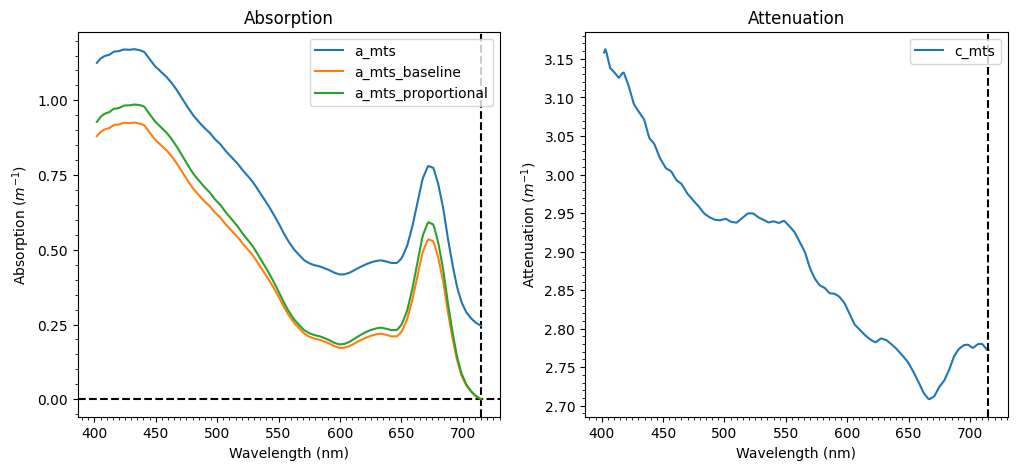

In [33]:
spectrum = acs.sel(time = acs.time.values[-51000])
dt = spectrum.time.values
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex = True)

ax[0].set_title('Absorption')
ax[0].axhline(0, color = 'k', linestyle = '--')
ax[0].axvline(reference_wavelength, color = 'k', linestyle = '--')
ax[0].plot(spectrum.wavelength, spectrum.a_mts, label='a_mts')
ax[0].plot(spectrum.wavelength, spectrum.a_mts_baseline, label = 'a_mts_baseline')
ax[0].plot(spectrum.wavelength, spectrum.a_mts_proportional, label = 'a_mts_proportional')
ax[0].legend(loc = 'upper right', ncols = 1)
ax[0].yaxis.set_major_locator(MultipleLocator(0.25))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))

ax[1].set_title('Attenuation')
ax[1].plot(spectrum.wavelength, spectrum.c_mts, label = 'c_mts')
ax[1].axvline(reference_wavelength, color = 'k', linestyle = '--')
ax[1].legend(loc = 'upper right', ncols = 1)
ax[1].yaxis.set_major_locator(MultipleLocator(0.05))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.01))

ax[-1].xaxis.set_major_locator(MultipleLocator(50))
ax[-1].xaxis.set_minor_locator(MultipleLocator(5))

ax[0].set_ylabel(r'Absorption ($m^{-1}$)')
ax[1].set_ylabel(r'Attenuation ($m^{-1}$)')
ax[0].set_xlabel('Wavelength (nm)')
ax[1].set_xlabel('Wavelength (nm)')

### Step 6.0: Smooth Data

For simplicity, we will apply a median filter with a centered window width of 13 to attenuation. It may be more appropriate to bin the data by depth, but the OOI does not provide unique profile identifiers, so estimation of a profile would need to be done. That is outside the scope of this example.

In [34]:
a = acs.a_mts_proportional.rolling({'time': 25}, center = True, min_periods = 1).median(skipna = True)
a = acsproc.zero_shift_correction(mts = a)

a = a.where(a<10, drop = True)  # Remove values greater than 10 m^-1. 

### Step 7.0: Compute Advanced Data Products
In this example we compute chlorophyll-a from absorption line height using the methods from Roesler and Barnard, 2013. 
It should be noted that this algorithm technically calls for the particulate signal, but the OOI does not take the dissolved samples to calculate the particulate signal.

In [35]:
a650 = a.sel(wavelength = 650, method = 'nearest') 
a676 = a.sel(wavelength = 676, method = 'nearest') 
a715 = a.sel(wavelength = 715, method = 'nearest') 

acs['estimated_chl'] = estimate_chl(a650,a676,a715,0.02) # Using larger alh_coeff.
acs['estimated_chl'] = acs['estimated_chl'].where(acs.estimated_chl > 0, 0) # Values less than 0 are set to 0. Probably from spectra that were not flagged appropriately.
acs['estimated_chl']  = acs.estimated_chl.rolling({'time':4 * 3 + 1}, center = True, min_periods = 1).median(skipna = True)

In [36]:
print(f"\nVariable Attributes")
print(acs.estimated_chl.attrs)


Variable Attributes
{'ancillary_variables': 'a_mts_proportional', 'alh_coeff': 0.02, 'long_name': 'Chlorophyll-a Concentration from Absorption Line Height', 'units': 'mg/m^3', 'estimation_method': 'Roesler and Barnard (2013)', 'method_data_source': 'Cultures and Gulf of Maine', 'reference': 'Roesler and Barnard (2013)', 'reference_doi': 'https://doi.org/10.1016/j.mio.2013.12.003'}


## Download Fluorometer Data

In [37]:
fl = download_and_load_goldcopy('https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/ooigoldcopy/public/CE02SHSP-SP001-07-FLORTJ000-recovered_cspp-flort_sample/deployment0013_CE02SHSP-SP001-07-FLORTJ000-recovered_cspp-flort_sample_20190624T165545.113000-20190627T023924.529000.nc')
fl = fl.swap_dims({'obs':'time'})
fl = fl[['fluorometric_chlorophyll_a']]
fl = fl.rolling({'time': 2*3 + 1}, center = True, min_periods = 1).median(skipna = True)

# Plot Data



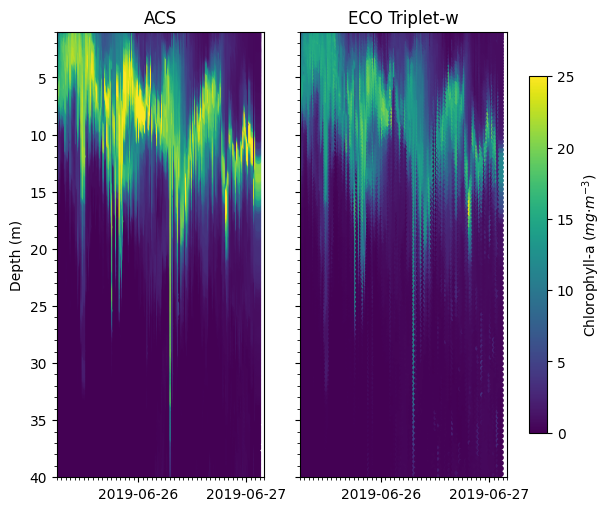

In [38]:
cmap = matplotlib.colormaps.get_cmap('viridis')

fig, ax = plt.subplots(1,2,figsize = (6,5), constrained_layout = True, sharex = True, sharey = True)

p0 = ax[0].scatter(acs.time, acs.depth, c = acs.estimated_chl, cmap = cmap, s = 10, vmin = 0, vmax = 25)

p1 = ax[1].scatter(fl.time, fl.depth, c = fl.fluorometric_chlorophyll_a, cmap = cmap, s = 10, vmin = 0, vmax = 25)


ax[-1].set_ylim(1,40)
ax[-1].invert_yaxis()

ax[0].set_title('ACS')
ax[1].set_title('ECO Triplet-w')

ax[0].set_ylabel('Depth (m)')

ax[-1].set_xlim(datetime(2019,6,25,6),datetime(2019,6,27,4))
ax[-1].xaxis.set_major_locator(DayLocator(interval = 1))
ax[-1].xaxis.set_minor_locator(HourLocator(interval = 1))

ax[-1].yaxis.set_major_locator(MultipleLocator(5))
ax[-1].yaxis.set_minor_locator(MultipleLocator(1))

fig.colorbar(p1, ax = ax[1], label = r'Chlorophyll-a (${mg}{\cdot}{m^{-3}}$)',shrink = 0.8, pad = 0.001)

plt.savefig('f4.jpg', dpi = 600)

# Export Data

To export data to a new netCDF, you can use Xarray's builtin to_netcdf function. It is important to define the time encoding so that other programming languages can interpret the time units correctly (Python, MATLAB, R, etc.).


<br>

```
from acspype.core import NC_ENCODING
acs.to_netcdf('processed.nc', encoding=NC_ENCODING)
```